In [252]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Electricity consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 01/04/25

### **Library**

In [ ]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit

# Machine Learning Libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
							  ExtraTreesClassifier, ExtraTreesRegressor, 
							  BaggingClassifier, BaggingRegressor, 
							  GradientBoostingClassifier, GradientBoostingRegressor, 
							  AdaBoostClassifier, AdaBoostRegressor, 
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
import xgboost as xgb

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer, 
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Hyperparameter Tuning with Bayesian Optimization
from hyperopt import hp, tpe, fmin, Trials

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score, 
							 roc_curve, auc, roc_auc_score, RocCurveDisplay, 
							 confusion_matrix, ConfusionMatrixDisplay, 
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
import statsmodels.api as sm



### **Data Preparation**

**Data source**

1. 한국전력공사(KEPCO) - https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000171&redirect=Y
2. 기상청 - https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36


**Electricity consumption**
- 840 samples in total
- Jan 2015 to Dec 2024
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daeguu
	- Ulsann
	- Gwangjuu
	- Busan
- 9 Features
	- Year
	- Month
	- Province
	- Number of Households
	- Avg Power Consumption per Household (kWh)
	- Avg Electricity Bill per Household (KRW)
	- Number of Tropical Nights
	- Number of Heatwave Days
	- Number of Coldwave Days

In [254]:
# Load electricity consumption data
df_electricity = pd.read_csv('data/electricity_consumption_eng.csv', encoding='utf-8')
df_electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Year                                       840 non-null    int64 
 1   Month                                      840 non-null    int64 
 2   Province                                   840 non-null    object
 3   Number of Households                       840 non-null    int64 
 4   Avg Power Consumption per Household (kWh)  840 non-null    int64 
 5   Avg Electricity Btill per Household (KRW)  840 non-null    int64 
 6   Number of Tropical Nights                  840 non-null    int64 
 7   Number of Heatwave Days                    840 non-null    int64 
 8   Number of Coldwave Days                    840 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 59.2+ KB


**Weather forecast**
- 861 samples in total
- Jan 2015 to Feb 2025
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daegu
	- Ulsan
	- Gwangju
	- Busan
- 21 Features
	- Station Name                  
	- Year                            
	- Month                          
	- Avg Temperature (Celsius)      
	- Avg Max Temperature (Celsius) 
	- Avg Min Temperature (Celsius) 
	- Avg Local Pressure (hPa)      
	- Avg Sea Level Pressure (hPa)  
	- Avg Vapor Pressure (hPa)      
	- Avg Dew Point Temp (Celsius)  
	- Avg Relative Humidity (%)     
	- Monthly Precipitation (mm)    
	- Small Pan Evaporation (mm)    
	- Avg Wind Speed (m/s)          
	- Max Wind Speed (m/s)          
	- Avg Cloud Cover (1/10)        
	- Total Sunshine Hours (hr)     
	- Sunshine Rate (%)             
	- Total Solar Radiation (MJ/m^2)
	- Avg Min Surface Temp (Celsius)
	- Avg Ground Temp (Celsius) 

In [255]:
# Load weather forecast data
df_weather = pd.read_csv('data/weather_forecast_eng.csv', encoding='utf-8')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Station Name                    861 non-null    object 
 1   Year                            861 non-null    int64  
 2   Month                           861 non-null    int64  
 3   Avg Temperature (Celsius)       861 non-null    float64
 4   Avg Max Temperature (Celsius)   861 non-null    float64
 5   Avg Min Temperature (Celsius)   861 non-null    float64
 6   Avg Local Pressure (hPa)        861 non-null    float64
 7   Avg Sea Level Pressure (hPa)    861 non-null    float64
 8   Avg Vapor Pressure (hPa)        861 non-null    float64
 9   Avg Dew Point Temp (Celsius)    861 non-null    float64
 10  Avg Relative Humidity (%)       861 non-null    int64  
 11  Monthly Precipitation (mm)      861 non-null    float64
 12  Small Pan Evaporation (mm)      728 

In [256]:
# Check missing values
print(df_weather.isnull().sum())

Station Name                        0
Year                                0
Month                               0
Avg Temperature (Celsius)           0
Avg Max Temperature (Celsius)       0
Avg Min Temperature (Celsius)       0
Avg Local Pressure (hPa)            0
Avg Sea Level Pressure (hPa)        0
Avg Vapor Pressure (hPa)            0
Avg Dew Point Temp (Celsius)        0
Avg Relative Humidity (%)           0
Monthly Precipitation (mm)          0
Small Pan Evaporation (mm)        133
Avg Wind Speed (m/s)                0
Max Wind Speed (m/s)                0
Avg Cloud Cover (1/10)              6
Total Sunshine Hours (hr)           0
Sunshine Rate (%)                   0
Total Solar Radiation (MJ/m^2)     97
Avg Min Surface Temp (Celsius)      0
Avg Ground Temp (Celsius)           0
dtype: int64


In [257]:
# Handle missing values w/ ffill
df_weather.ffill(inplace=True)

In [258]:
# Re-check missing values
print(df_weather.isnull().sum())

Station Name                      0
Year                              0
Month                             0
Avg Temperature (Celsius)         0
Avg Max Temperature (Celsius)     0
Avg Min Temperature (Celsius)     0
Avg Local Pressure (hPa)          0
Avg Sea Level Pressure (hPa)      0
Avg Vapor Pressure (hPa)          0
Avg Dew Point Temp (Celsius)      0
Avg Relative Humidity (%)         0
Monthly Precipitation (mm)        0
Small Pan Evaporation (mm)        0
Avg Wind Speed (m/s)              0
Max Wind Speed (m/s)              0
Avg Cloud Cover (1/10)            0
Total Sunshine Hours (hr)         0
Sunshine Rate (%)                 0
Total Solar Radiation (MJ/m^2)    0
Avg Min Surface Temp (Celsius)    0
Avg Ground Temp (Celsius)         0
dtype: int64


In [259]:
# Create Date column using Year and Month columns
df_electricity['Date'] = pd.to_datetime(arg=dict(year=df_electricity['Year'], month=df_electricity['Month'], day=1))
df_weather['Date'] = pd.to_datetime(arg=dict(year=df_weather['Year'], month=df_weather['Month'], day=1))

# Drop Year and Month columns
df_electricity = df_electricity.drop(columns=['Year', 'Month'])
f_weather = df_weather.drop(columns=['Year', 'Month'])

# Rename Station Name and Province to Location
df_electricity = df_electricity.rename(columns={'Province': 'Location'})
df_weather = df_weather.rename(columns={'Station Name': 'Location'})

# Merge df_weather and df_electricity based on Date and Location
df_merged = pd.merge(df_electricity, df_weather, on=['Date', 'Location'], how='inner') # Inner join based on Date and Location
df_merged['Year'] = df_merged['Date'].dt.year
df_merged['Month'] = df_merged['Date'].dt.month
df_merged = df_merged[['Date'] + [col for col in df_merged.columns if col != 'Date']] # Bring Date column to the front
df_merged.to_csv('data/merged_data.csv', index=False, encoding='utf-8')

In [260]:
df_merged.columns

Index(['Date', 'Location', 'Number of Households',
       'Avg Power Consumption per Household (kWh)',
       'Avg Electricity Btill per Household (KRW)',
       'Number of Tropical Nights', 'Number of Heatwave Days',
       'Number of Coldwave Days', 'Year', 'Month', 'Avg Temperature (Celsius)',
       'Avg Max Temperature (Celsius)', 'Avg Min Temperature (Celsius)',
       'Avg Local Pressure (hPa)', 'Avg Sea Level Pressure (hPa)',
       'Avg Vapor Pressure (hPa)', 'Avg Dew Point Temp (Celsius)',
       'Avg Relative Humidity (%)', 'Monthly Precipitation (mm)',
       'Small Pan Evaporation (mm)', 'Avg Wind Speed (m/s)',
       'Max Wind Speed (m/s)', 'Avg Cloud Cover (1/10)',
       'Total Sunshine Hours (hr)', 'Sunshine Rate (%)',
       'Total Solar Radiation (MJ/m^2)', 'Avg Min Surface Temp (Celsius)',
       'Avg Ground Temp (Celsius)'],
      dtype='object')

In [261]:
# Data split for features and target
X = df_merged.drop(columns=['Avg Power Consumption per Household (kWh)'])
y = df_merged['Avg Power Consumption per Household (kWh)']

In [262]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns
target_col = y.name

### **Visualization**

In [ ]:
def dual_mean_plot(a: str,b: str, c='Month'):
	'''
	This function generates a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.

	Output:
	A dual-axis plot with bars of a and an line of b averaged on c.
	'''

	monthly_data = df_merged.groupby(c)[[a,b]].mean().reset_index()
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(monthly_data[c], monthly_data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')
	#######
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(monthly_data[c], monthly_data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	plt.title(f'{a} & {b} from 2015 to 2024')
	plt.grid()
	plt.tight_layout()

	plt.show()

In [ ]:
def one_feature_two_group (a,b:str,c:str): #a: Main Category b:Subcategory c:feature ex)서울, 감수량,가구
	"""
	Plots the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.
	
	Parameters:
	a (str): Name of the main category column in df_merged (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df_merged (e.g., a more granular group like 'City').
	c (str): Name of the feature/metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean=df_merged.groupby([f'{a}',f'{b}'])[c].mean()
	plt.figure(figsize=(12, 8))
	unstacked_df = df_mean.unstack(level=f'{a}')
	unstacked_df .plot(kind='line',marker='o',ax=plt.gca())

	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')

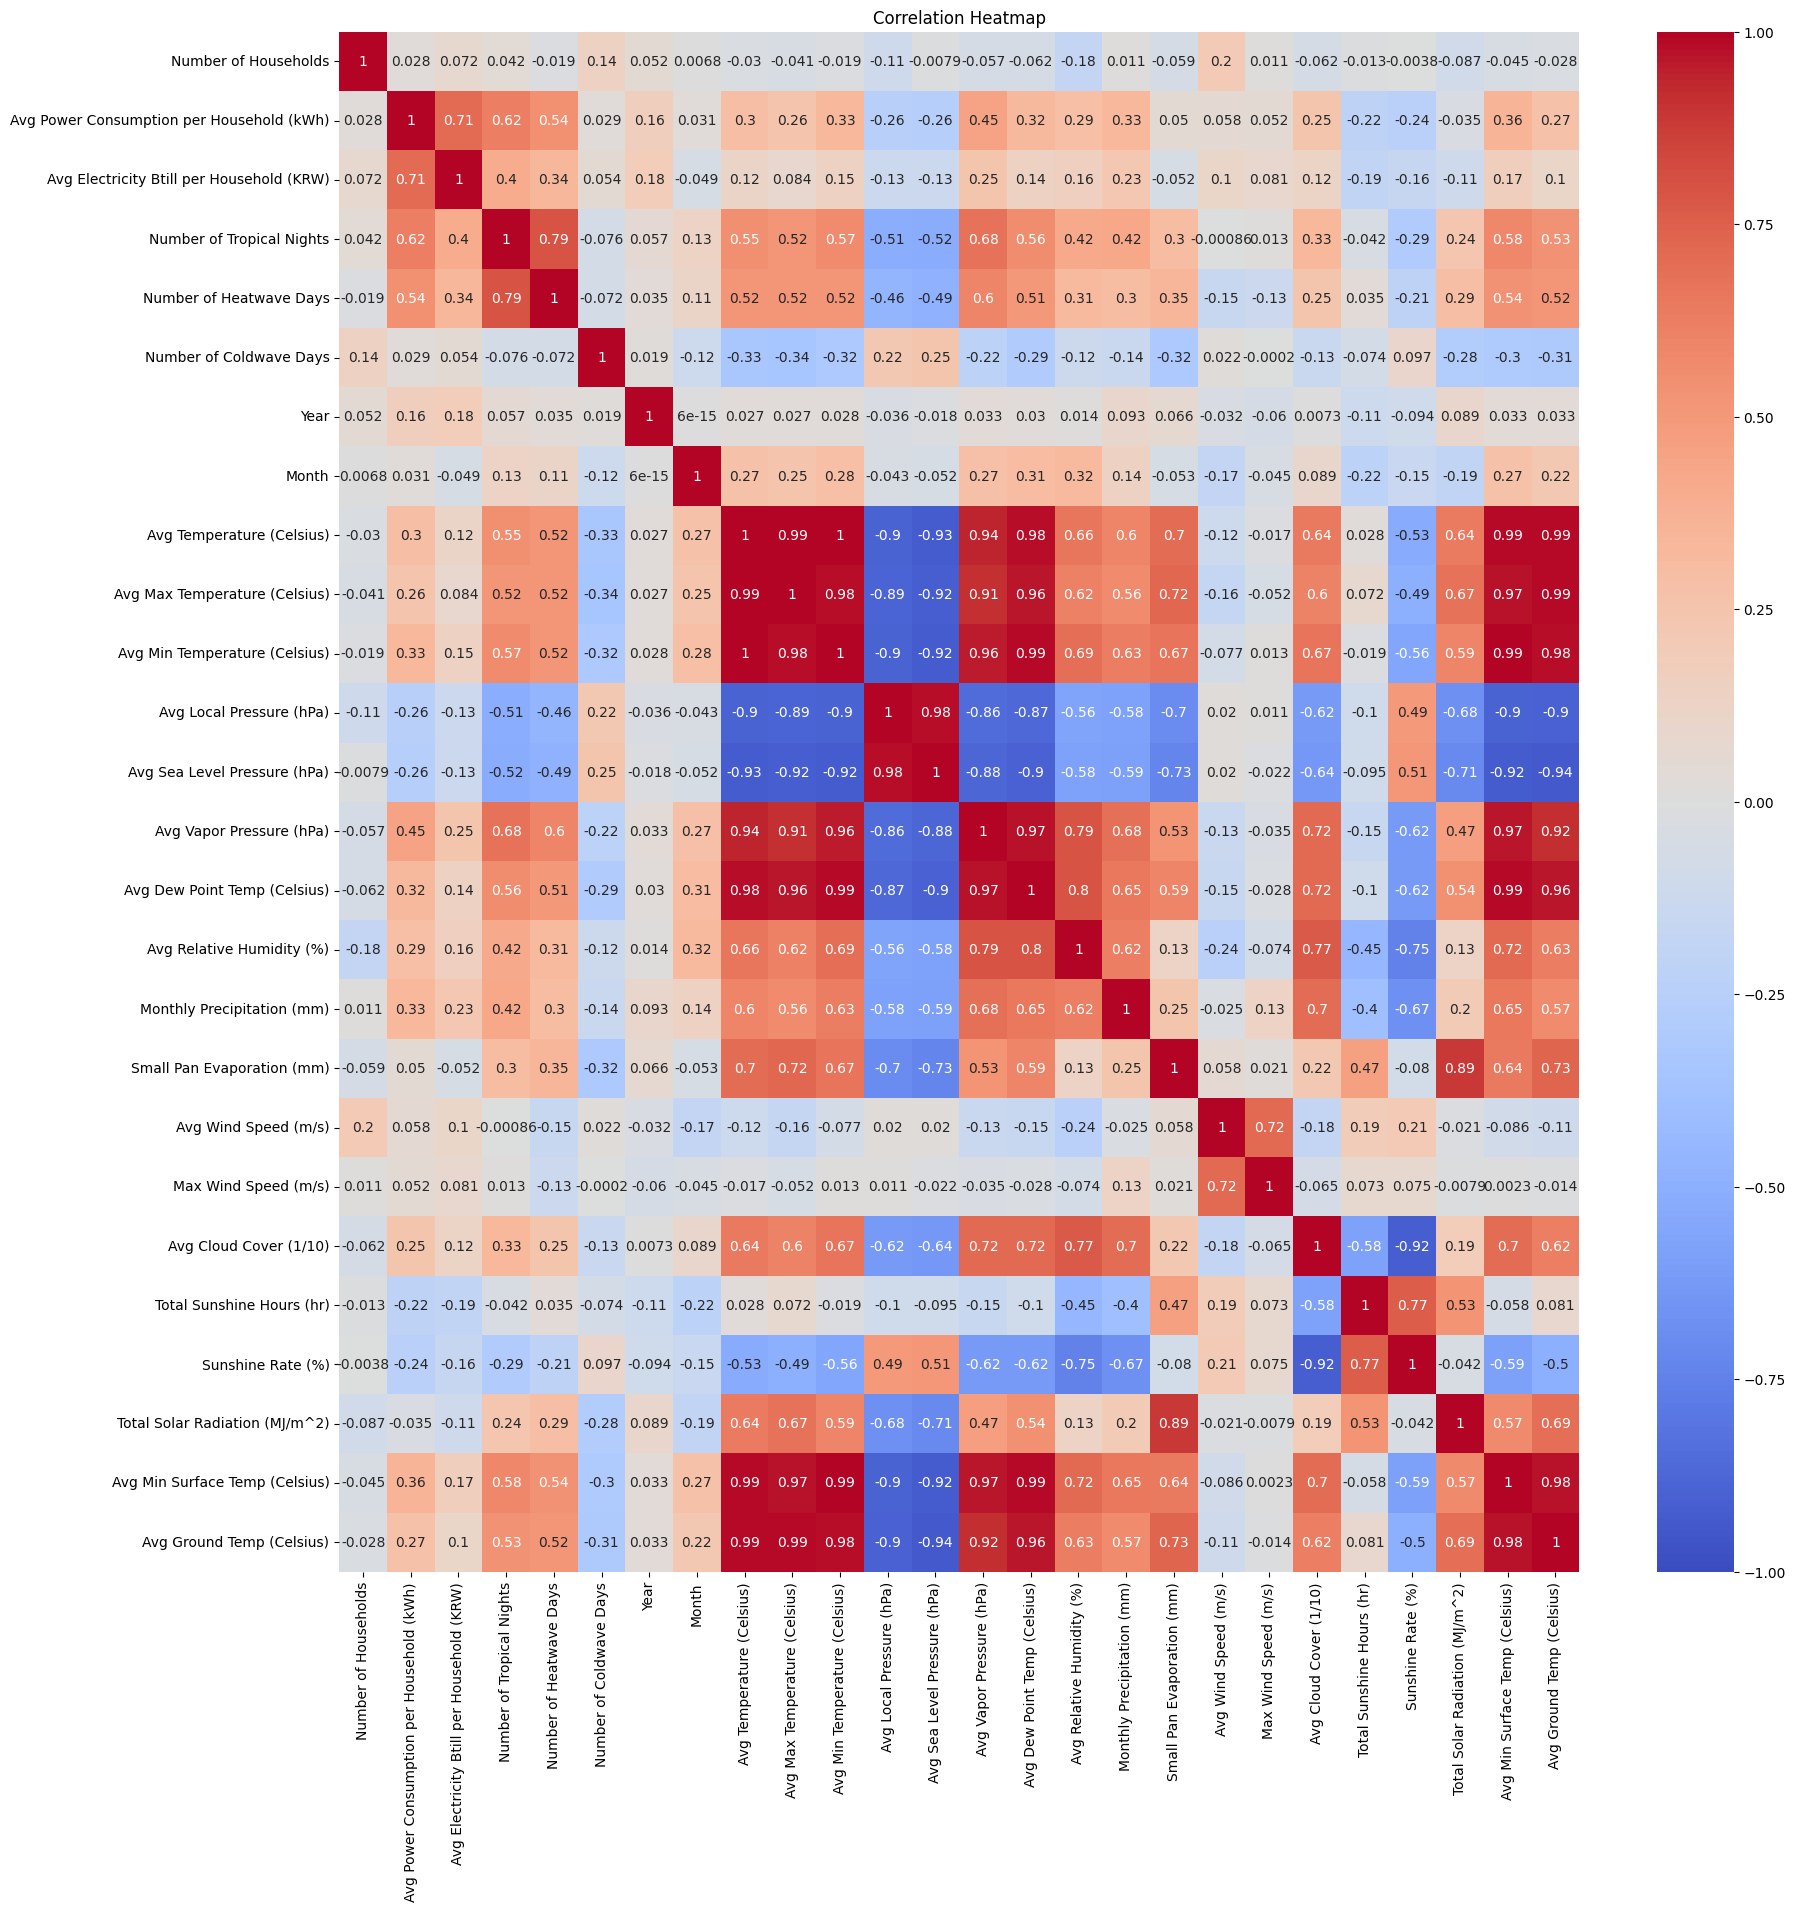

In [304]:
#heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

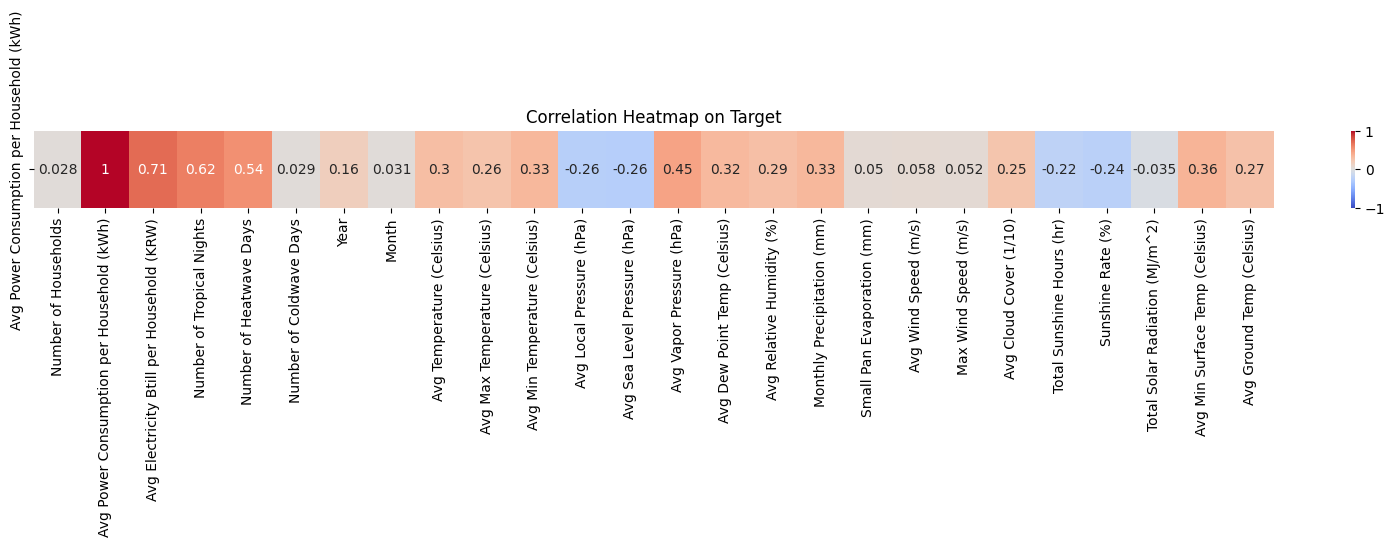

In [306]:
#heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
df_corr_find = df_corr.copy()
low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
df_corr=df_corr.iloc[[1]]
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,1))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

In [266]:
print(low_cols) 

Index(['Number of Households', 'Number of Coldwave Days', 'Year', 'Month',
       'Small Pan Evaporation (mm)', 'Avg Wind Speed (m/s)',
       'Max Wind Speed (m/s)', 'Total Solar Radiation (MJ/m^2)'],
      dtype='object')


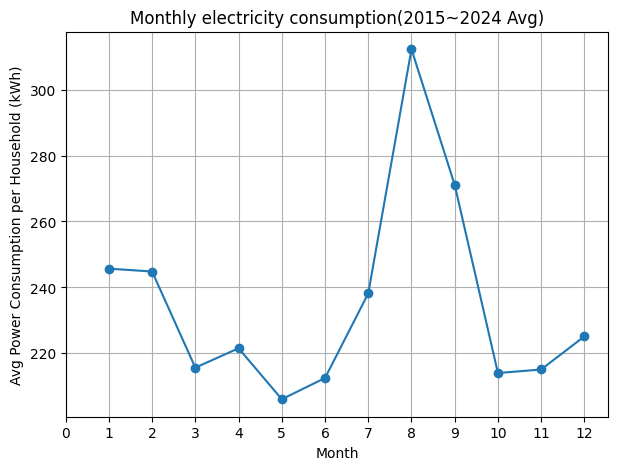

In [303]:
# Monthly Avg electricity consumption barplot

ele_plt = df_merged.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

plt.figure(figsize=(7, 5))
ele_plt.plot(kind='line', marker='o')
plt.title("Monthly electricity consumption(2015~2024 Avg)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.xticks(np.arange(0,13,1),rotation=0)
plt.grid()
plt.show()

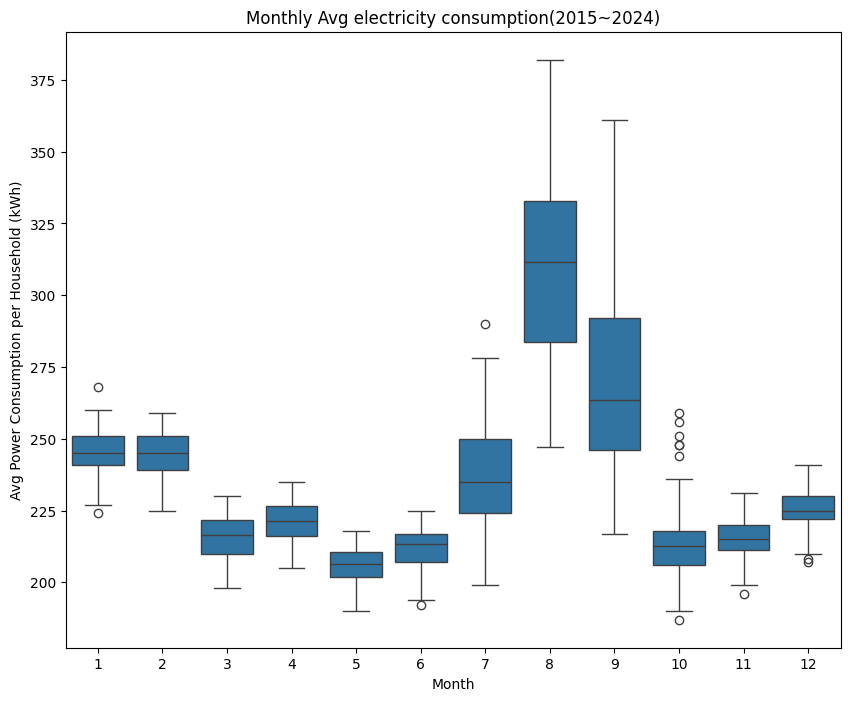

In [279]:
# Monthly Avg electricity consumption boxplot

plt.figure(figsize=(10, 8))
sns.boxplot(data=df_merged, x='Month', y='Avg Power Consumption per Household (kWh)')
plt.title("Monthly Avg electricity consumption(2015~2024)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.show()

In [ ]:
# Monthly temperature plot
dual_mean_plot(a='Avg Temperature (Celsius)', b='Avg Cloud Cover (1/10)', c='Month')


KeyError: "Columns not found: '여'"

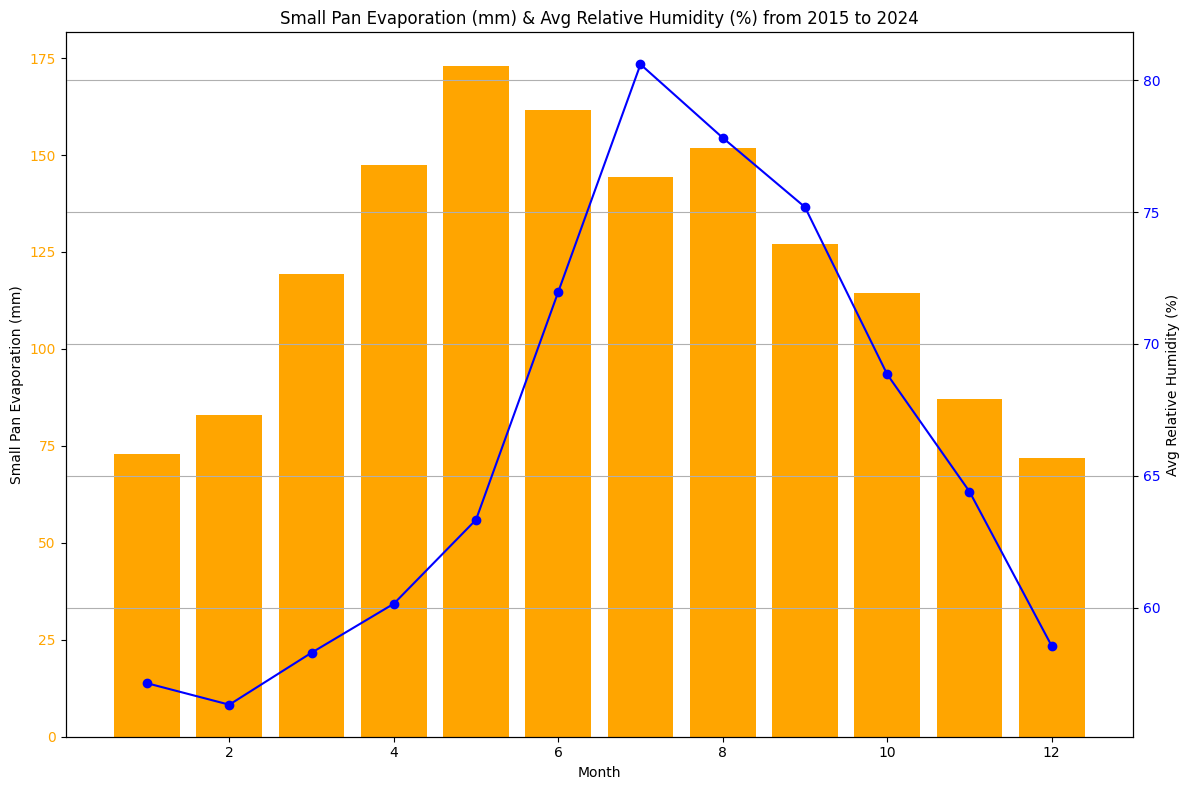

In [285]:
# Number of heatwave days and avg power consumption per household by year
dual_mean_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

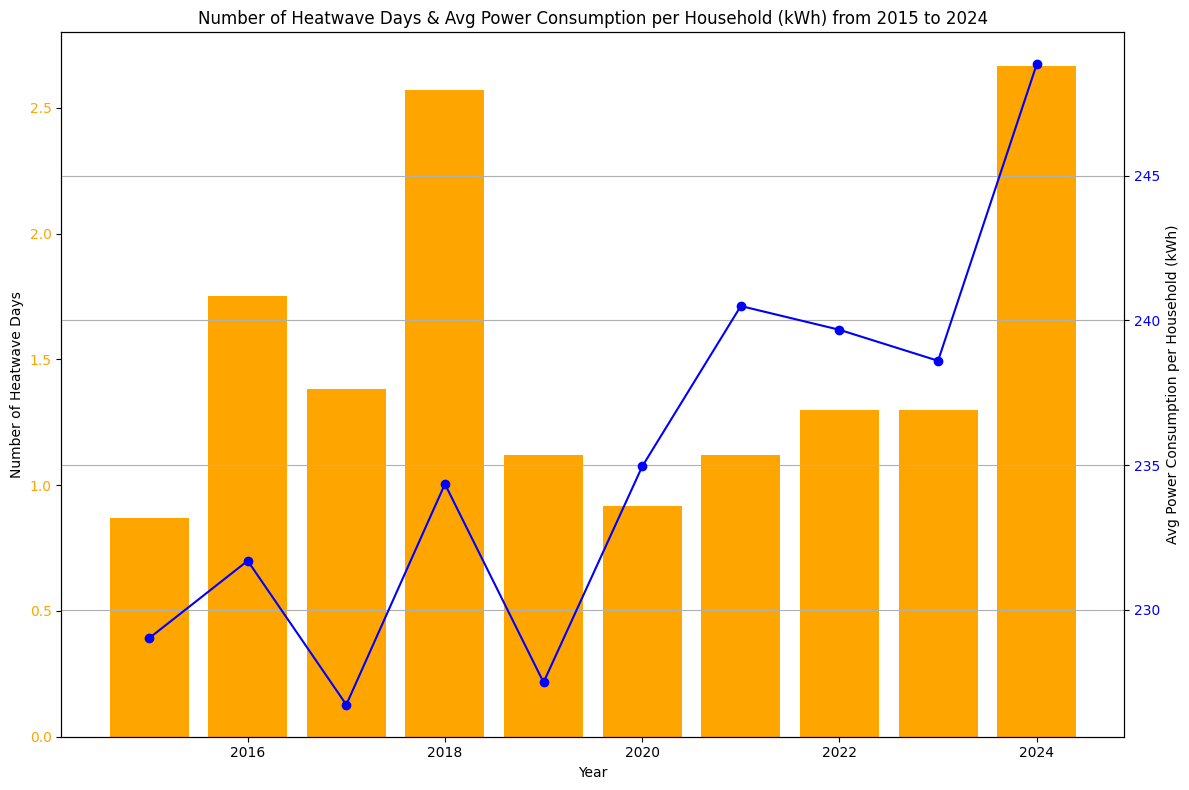

In [244]:
# Number of heatwave days and avg power consumption per household by year
dual_mean_plot(a='Number of Heatwave Days',b='Avg Power Consumption per Household (kWh)',c='Year')


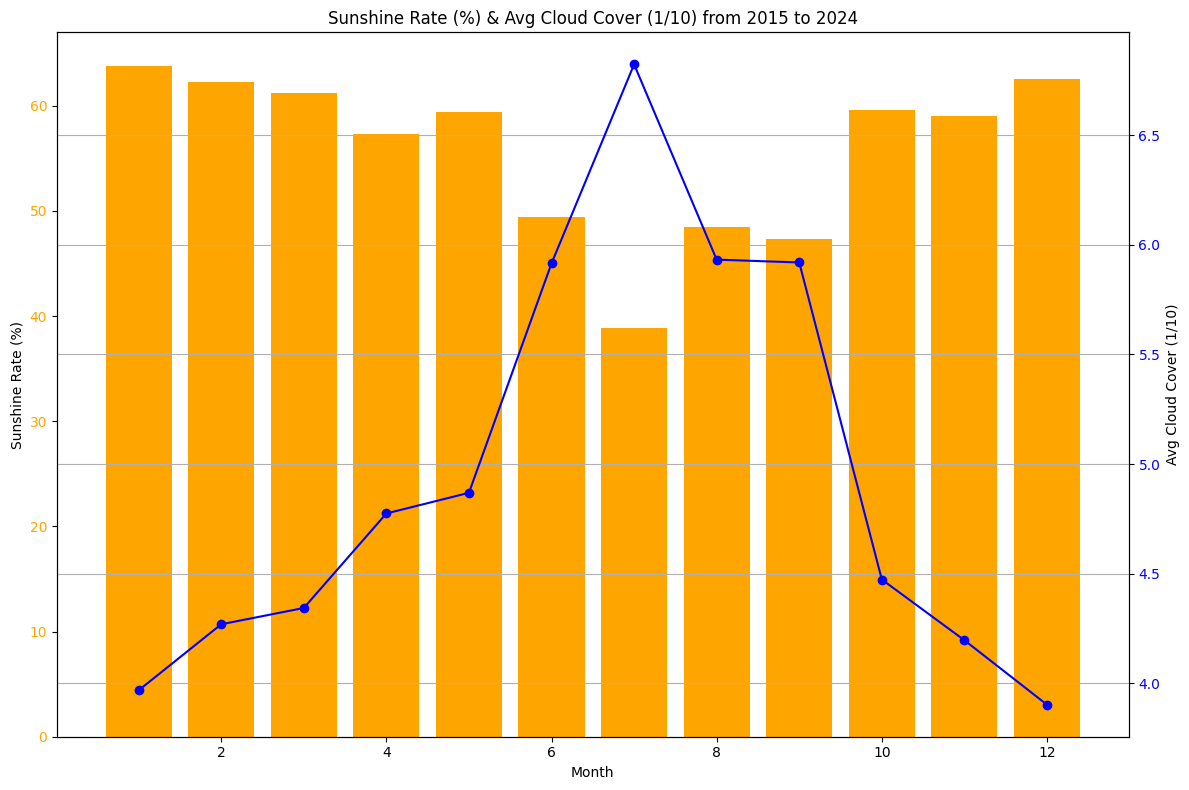

In [245]:
# Sunshine and avg cloud cover by month
dual_mean_plot(a='Sunshine Rate (%)', b='Avg Cloud Cover (1/10)', c='Month')

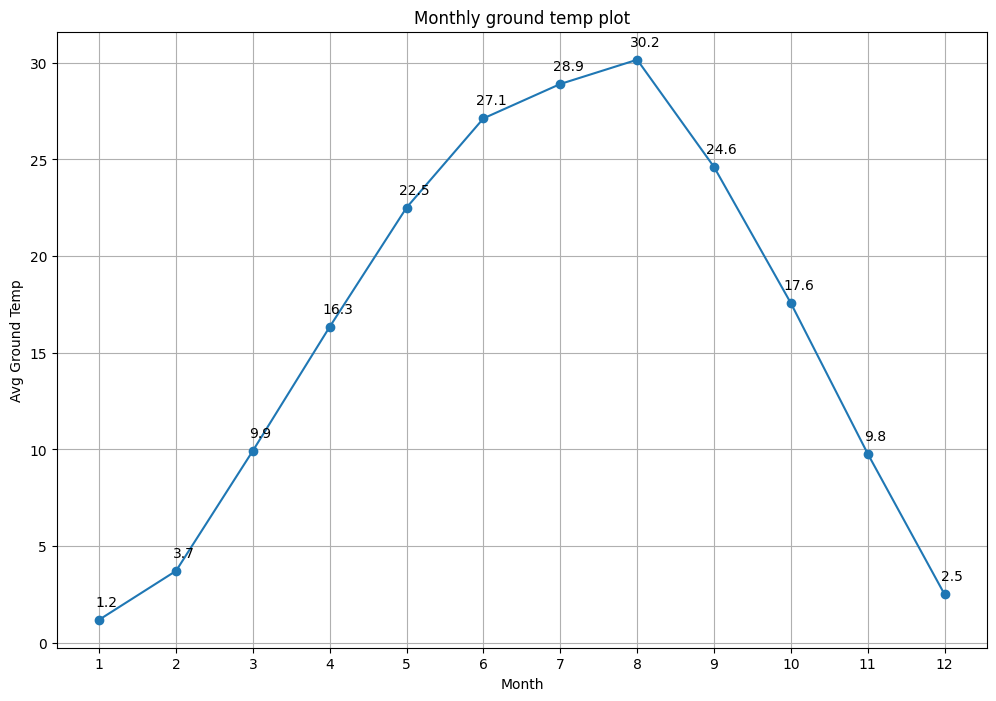

In [290]:
# Monthly ground temp plot(month)
df=df_merged.copy()
#Avg Ground Temp (Celsius)  
df_sum=df.groupby('Month')['Avg Ground Temp (Celsius)'].sum()
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()
plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

# def one_mean_line_text(a,b): # a=category b=feature
# 	df_mean=df_merged.groupby(f'{a}')[f'{b}'].mean()
# 	plt.figure(figsize=(12, 8))
# 	df_mean.plot(kind='line',marker='o')
# 	plt.xticks(df_mean.index)
# 	plt.xlabel(f'{a}')
# 	plt.ylabel(f'{b}')
# 	plt.title(f'{a} {b} plot')
# 	for x_val, y_val in df_mean.items():
# 		plt.text(x_val+0.1,y_val+0.4,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
# 	plt.grid()
# 	plt.show()

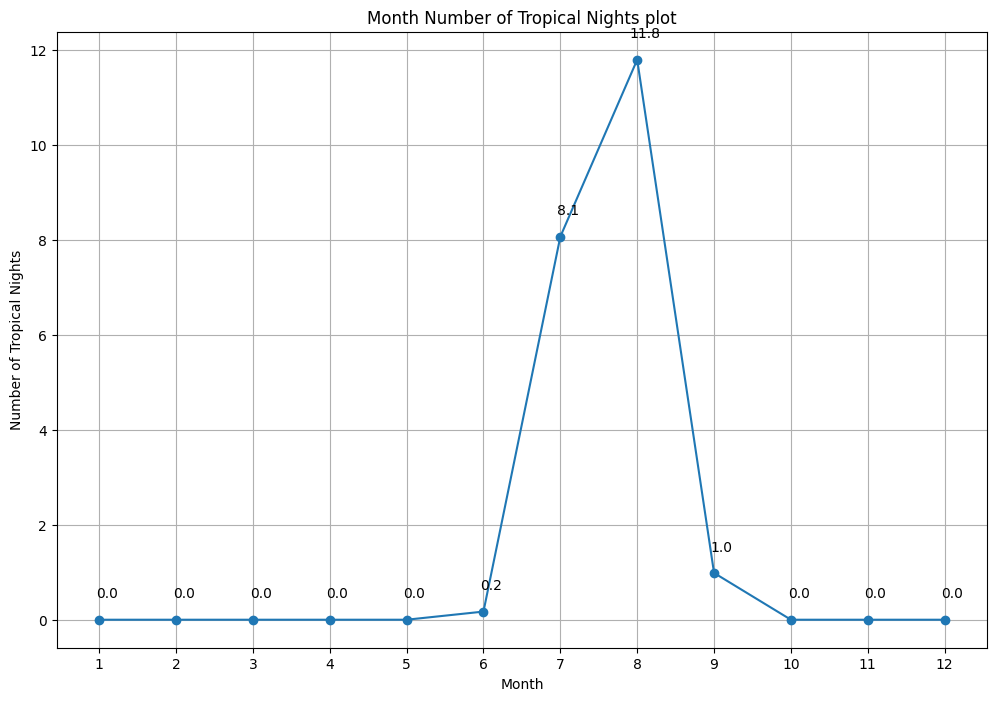

In [289]:
one_mean_line_text('Month','Number of Tropical Nights')

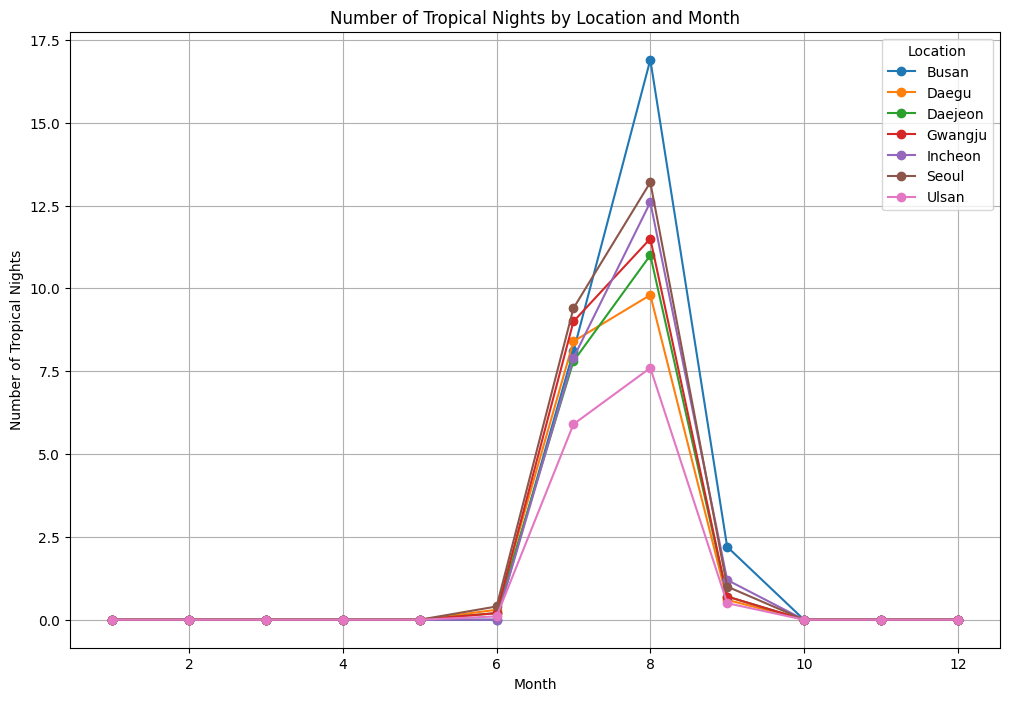

In [247]:
one_feature_two_group('Location','Month','Number of Tropical Nights')

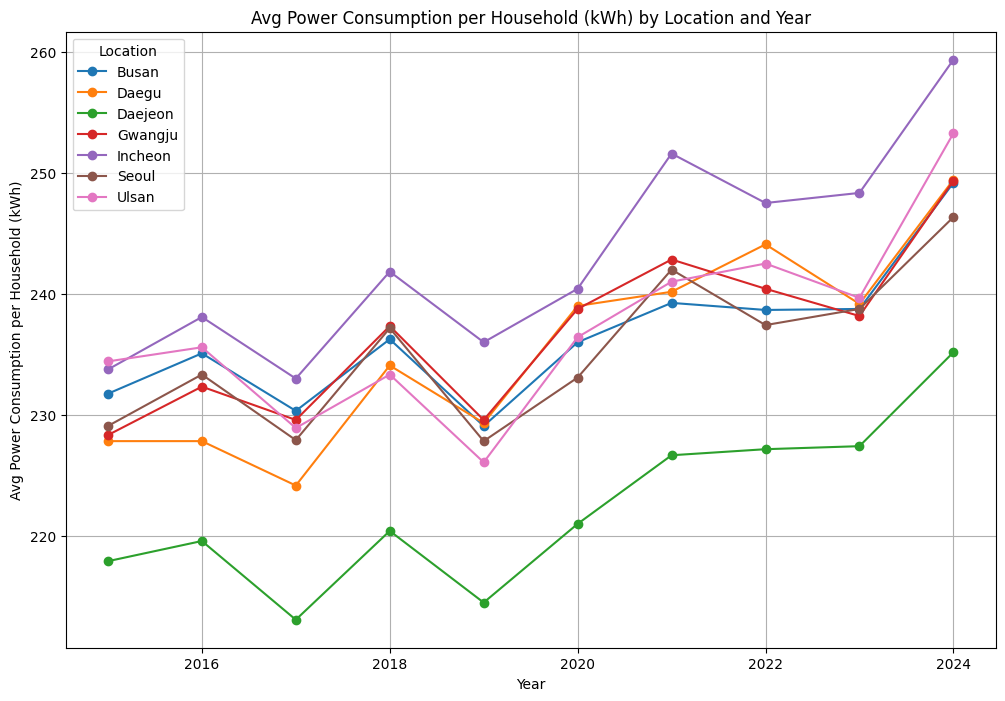

In [248]:
one_feature_two_group('Location','Year','Avg Power Consumption per Household (kWh)')

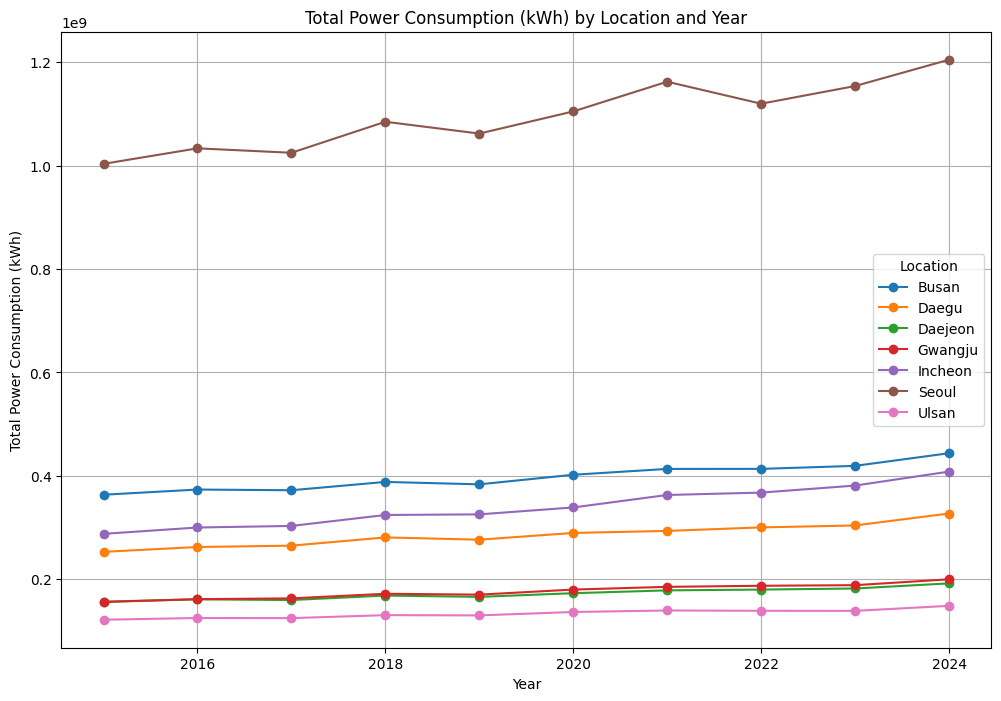

In [ ]:
df_merged['Total Power Consumption (kWh)'] = df_merged['Number of Households'] * df_merged['Avg Power Consumption per Household (kWh)']
one_feature_two_group('Location','Year','Total Power Consumption (kWh)')

### **Data Preprocessing**